In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("dataset_b_msme.csv")
df.head()

,Applied Loan Amount,Applied Loan Tenor,Loan Purpose,Gender,Age,Marital Status,Education Level,Residential Status,Monthly Housing/Rental,Contract Staff (Y/N),Employment Type,Nature of Business,Job Position,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators
0,200000,60,Personal use,M,59.482,Married,University,Mortgaged Private Housing,15182.0,N,Self-Employed,Owner of a Business,Self Employed,30000.0,0,0,1,0,0
1,100000,24,Personal use,M,49.745,Married,Secondary,Live With Relatives,0.0,N,Self-Employed,Owner of a Business,Self Employed,50000.0,1,0,0,0,0
2,286000,60,Personal use,F,55.584,Married,Secondary,Live With Relatives,0.0,N,Self-Employed,Owner of a Business,Self Employed,28600.0,0,0,1,0,0
3,190000,36,Personal use,F,56.677,Single,Post Secondary,Self-owned Private Housing,10000.0,N,Self-Employed,Owner of a Business,Self Employed,19800.0,1,0,0,0,0
4,50000,48,Settle Loan / Credit Card O/S,F,39.699,Married,Secondary,Self-owned Private Housing,0.0,N,Non Fixed Income Earner,Owner of a Business,Self Employed,13000.0,0,0,1,0,0


In [ ]:
df = df.dropna()

In [ ]:
# df = df.astype(np.float64)
# df["Final_Status (Y/N)"].astype(int)
df.dtypes

Applied Loan Amount         int64
Applied Loan Tenor          int64
Loan Purpose               object
Gender                     object
Age                       float64
Marital Status             object
Education Level            object
Residential Status         object
Monthly Housing/Rental    float64
Contract Staff (Y/N)       object
Employment Type            object
Nature of Business         object
Job Position               object
Monthly Income            float64
Office (Area)_1             int64
Office (Area)_2             int64
Office (Area)_3             int64
Office (Area)_6             int64
Indicators                  int64
dtype: object

In [ ]:
df = pd.get_dummies(df)
df.head()

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Indicators,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Investment,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,Residential Status_Mortgaged Private Housing,Residential Status_Mortgaged Public Housing,Residential Status_No Response,Residential Status_Rental,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_Owner of a Business,Job Position_Self Employed
0,200000,60,59.482,15182.0,30000.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1
1,100000,24,49.745,0.0,50000.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1
2,286000,60,55.584,0.0,28600.0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1
3,190000,36,56.677,10000.0,19800.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1
4,50000,48,39.699,0.0,13000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1


In [ ]:
cols = df.columns.tolist()
cols.remove('Indicators')
cols.append('Indicators')
df = df[cols]
df.head() 

,Applied Loan Amount,Applied Loan Tenor,Age,Monthly Housing/Rental,Monthly Income,Office (Area)_1,Office (Area)_2,Office (Area)_3,Office (Area)_6,Loan Purpose_Business,Loan Purpose_Car Purchase,Loan Purpose_Decoration,Loan Purpose_Education,Loan Purpose_Investment,Loan Purpose_Personal use,Loan Purpose_Settle Loan / Credit Card O/S,Loan Purpose_Stand by,Loan Purpose_Tax Payment,Gender_F,Gender_M,Marital Status_Divorced,Marital Status_Married,Marital Status_No Response,Marital Status_Single,Marital Status_Widowed,Education Level_Form 3 or below,Education Level_No Response,Education Level_Post Graduate,Education Level_Post Secondary,Education Level_Primary,Education Level_Secondary,Education Level_University,Residential Status_Company Provision,Residential Status_Live With Relatives,Residential Status_Mortgaged Private Housing,Residential Status_Mortgaged Public Housing,Residential Status_No Response,Residential Status_Rental,Residential Status_Self-owned Private Housing,Residential Status_Self-owned Public Housing,Contract Staff (Y/N)_N,Contract Staff (Y/N)_Y,Employment Type_Fixed Income Earner,Employment Type_Non Fixed Income Earner,Employment Type_Self-Employed,Employment Type_Self-Employed Professional,Nature of Business_Owner of a Business,Job Position_Self Employed,Indicators
0,200000,60,59.482,15182.0,30000.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1,0
1,100000,24,49.745,0.0,50000.0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
2,286000,60,55.584,0.0,28600.0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0
3,190000,36,56.677,10000.0,19800.0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,1,0
4,50000,48,39.699,0.0,13000.0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,0


In [ ]:
df.shape

(736, 49)

In [ ]:
# df['Class_att'] = df['Class_att'].astype('category')
# encode_map = {
#     'Abnormal': 1,
#     'Normal': 0
# }

# df['Class_att'].replace(encode_map, inplace=True)

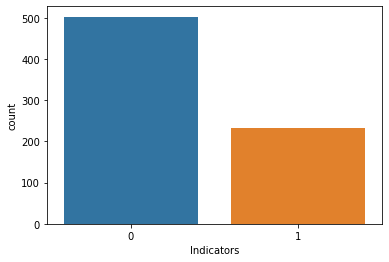

In [ ]:
sns.countplot(x = 'Indicators', data=df)

In [ ]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [ ]:
print(X.shape, y.shape)

(736, 48) (736,)


In [ ]:
np.any(np.isnan(y))

False

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
print(X_train.shape, X_test.shape)

(493, 48) (243, 48)


In [ ]:
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [ ]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(torch.Tensor(y_train.values)))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [ ]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) # may need increase later

In [ ]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(48, 160) 
        self.layer_2 = nn.Linear(160, 40)
        self.layer_out = nn.Linear(40, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(160)
        self.batchnorm2 = nn.BatchNorm1d(40)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
###############

cpu


In [ ]:
model = binaryClassification()
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=48, out_features=160, bias=True)
  (layer_2): Linear(in_features=160, out_features=40, bias=True)
  (layer_out): Linear(in_features=40, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
e_loss = []
e_acc = []
timelist = []
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    start_time = time.time()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    total_time = time.time() - start_time
    timelist.append(total_time)
    e_loss.append(epoch_loss/len(train_loader)) # for plt
    e_acc.append(epoch_acc/len(train_loader)) # for plt
    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Time: {total_time:.3f}')

Epoch 001: | Loss: 0.69073 | Acc: 53.250 | Time: 0.164
Epoch 002: | Loss: 0.68357 | Acc: 57.500 | Time: 0.022
Epoch 003: | Loss: 0.67898 | Acc: 57.375 | Time: 0.022
Epoch 004: | Loss: 0.66319 | Acc: 61.750 | Time: 0.022
Epoch 005: | Loss: 0.65267 | Acc: 62.000 | Time: 0.025
Epoch 006: | Loss: 0.64584 | Acc: 64.375 | Time: 0.025
Epoch 007: | Loss: 0.64101 | Acc: 63.000 | Time: 0.023
Epoch 008: | Loss: 0.63788 | Acc: 65.250 | Time: 0.022
Epoch 009: | Loss: 0.63759 | Acc: 66.625 | Time: 0.023
Epoch 010: | Loss: 0.61550 | Acc: 69.125 | Time: 0.034
Epoch 011: | Loss: 0.61678 | Acc: 68.875 | Time: 0.022
Epoch 012: | Loss: 0.61376 | Acc: 68.875 | Time: 0.024
Epoch 013: | Loss: 0.61331 | Acc: 68.625 | Time: 0.022
Epoch 014: | Loss: 0.59920 | Acc: 71.375 | Time: 0.024
Epoch 015: | Loss: 0.60240 | Acc: 71.250 | Time: 0.022
Epoch 016: | Loss: 0.59475 | Acc: 72.750 | Time: 0.023
Epoch 017: | Loss: 0.59334 | Acc: 70.875 | Time: 0.023
Epoch 018: | Loss: 0.59462 | Acc: 72.375 | Time: 0.024
Epoch 019:

In [ ]:
n_list = np.arange(1, 501).tolist()
n_list = pd.Series(n_list)
time_list = pd.Series(timelist)

In [ ]:
time_list.corr(n_list)

-0.1637726617149273

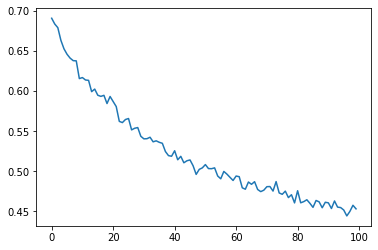

In [ ]:
plt.plot(e_loss)

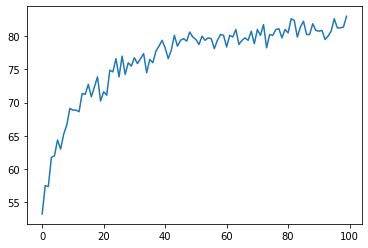

In [ ]:
plt.plot(e_acc)

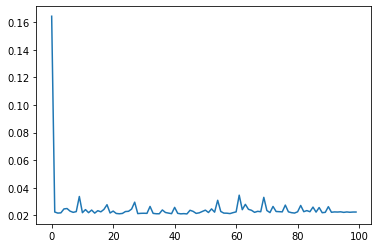

In [ ]:
plt.plot(timelist)

In [ ]:
import statistics
statistics.mean(timelist)

0.024816043376922607

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [ ]:
confusion_matrix(y_test, y_pred_list)

array([[129,  38],
       [ 22,  54]])

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       167
           1       0.59      0.71      0.64        76

    accuracy                           0.75       243
   macro avg       0.72      0.74      0.73       243
weighted avg       0.77      0.75      0.76       243

